In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

/home/a/a270042/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'isotdep'
year      = [1979, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = None
which_isotherm = 12.0


#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'wbgyr'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40531 instead
  warnings.warn(


Started a new Dask client: <Client: 'tcp://127.0.0.1:34361' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/40531/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/40531/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34361,Workers: 32
Dashboard: /user/a270042/levante-spawner-preset//proxy/40531/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:43681,Total threads: 2
Dashboard: /user/a270042/levante-spawner-preset//proxy/34359/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:40035,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo.update({'cref':0.0})
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 12    , 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : mesh.nlev-1, 
               'nz'   : mesh.nlev, 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of time chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.08
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
    # if   chunks['nod2'] != 'auto': chunk_size = chunk_size/chunks['nod2']    
    # elif chunks['elem'] != 'auto': chunk_size = chunk_size/chunks['elem']
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']            
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    chunks['elem'] = chunks['nod2'] = np.int32(np.ceil(chunk_size))
    print(' --> set nod2/elem chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))

#__________________________________________________________________________________________________    
def compute_isotherm_depth(data, which_isotherm):
    
    #__________________________________________________________________________________________________    
    vname = list(data.keys())[0]
    auxithermz = np.zeros((data.dims['nod2'], ))
    for ni in range(data.dims['nod2']):
        auxtemp, auxzmid = data[vname].isel(nod2=ni).data.copy(), np.abs(data.coords['nz1'].data.copy())
        if np.any(auxtemp>=which_isotherm):
            isok   = np.isnan(auxtemp)==False
            auxtemp, auxzmid = auxtemp[isok], auxzmid[isok]
            idsort = np.argsort(auxtemp)
            auxtemp, auxzmid = auxtemp[idsort], auxzmid[idsort]
            auxithermz[ni] = np.interp(which_isotherm, auxtemp, auxzmid)
            del(auxtemp, auxzmid, isok, idsort)
        else: continue 
    #__________________________________________________________________________________________________    
    isotdep = xr.Dataset(data_vars = {'isotdep': ('nod2', auxithermz, data['temp'].attrs)},
                             coords    = {'lon'    : data.coords['lon'], 
                                          'lat'    : data.coords['lat'], 
                                          'w_A'    : data.coords['w_A'].isel(nz1=0)},
                             attrs     = data.attrs)
    isotdep['isotdep'].attrs['long_name'  ] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['description'] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['units'      ] = 'm'
    isotdep.attrs['proj'] = proj
    #__________________________________________________________________________________________________    
    return(isotdep)    


#______________________________________________________________________________________________________
# compute isotherm depth for each chunk block, hereby its important that the vertical dimension
# nz1 is NOT chunked and consecutive
def isotherm_depth_chnk(temp_chnk, depth_vals, which_isotherm):
    import dask.array as da
    """Efficiently compute the isotherm depth for each node."""
    nod2, nz1    = temp_chnk.shape
    
    # Replace NaNs with a large negative value to avoid issues
    temp_chnk    = da.where(da.isnan(temp_chnk), np.inf, temp_chnk)

    # Find below indices where temp crosses isotherm
    idx_below    = da.argmax(temp_chnk < which_isotherm, axis=1)
    # it can haben that some chunk contain no valid situation for 
    # temp_chnk < which_isotherm in this da.argmax would return an empty array
    if len(idx_below)==0: idx_below = da.zeros(nod2)

    # Find below indices where temp crosses isotherm
    idx_above    = idx_below-1

    # Find depth layers above below where isotherm crosses
    depth_below  = depth_vals[idx_below]
    depth_above  = depth_vals[idx_above]

    # if there is no valid isotherm crossing set depth layers to NaN
    depth_above  = da.where(idx_above<=-1, np.nan, depth_above)
    depth_below  = da.where(idx_above<=-1, np.nan, depth_below)
    
    # Create a tuple of indices for (nod2, idx_below)
    # Convert the tuple of indices into a linear index for the flattened temp_block
    # Use the linear index to get values from the flattened temp_chnk[nod2, nz1]
    flat_indices = da.arange(nod2) * nz1 + idx_below
    temp_below   = temp_chnk.flatten()[flat_indices]

    flat_indices = da.arange(nod2) * nz1 + idx_above
    temp_above   = temp_chnk.flatten()[flat_indices]
    del(flat_indices)

    # avoid division by zero
    denom_temp   = temp_below - temp_above
    denom_temp   = da.where(denom_temp == 0, np.nan, denom_temp)
    
    # linearly interpolate isotherm depth
    isothermz = depth_above + ((which_isotherm - temp_above) * (depth_below - depth_above) / denom_temp)
    
    return (isothermz)

#______________________________________________________________________________________________________    
def compute_isotherm_depth_dask(data, which_isotherm):
    import dask.array as da
    vname = list(data.keys())[0]  # Get temperature variable name
    #__________________________________________________________________________________________________    
    # Apply function to chunks over dask client 
    isothermz = da.map_blocks(isotherm_depth_chnk            , # input function isotherm_depth_chnk 
                              data[vname].data               , # temp_chunk
                              np.abs(data.coords['nz1'].data), # depth
                              which_isotherm                 , # which isotherm value 
                              dtype=np.float32, drop_axis=1
                             )
    isothermz = isothermz.compute()
    
    #__________________________________________________________________________________________________
    # build xarray dataset
    isotdep = xr.Dataset(data_vars = {'isotdep': ('nod2', isothermz, data[vname].attrs)},
                             coords    = {'lon'    : data.coords['lon'], 
                                          'lat'    : data.coords['lat'], 
                                          'w_A'    : data.coords['w_A'].isel(nz1=0)},
                             attrs     = data.attrs)
    isotdep['isotdep'].attrs['long_name'  ] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['description'] = 'depth of {}°C isotherm'.format(which_isotherm)
    isotdep['isotdep'].attrs['units'      ] = 'm'
    isotdep.attrs['proj'] = proj
    isotdep = isotdep.load()
    #__________________________________________________________________________________________________
    return(isotdep)  

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 549.32Mb
 --> set nod2/elem chunk size to 8.00% of worker mem.: 150000


In [5]:
t0 = clock.time()
data_list = list()

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (depth != 'bottom') and do_clim and (ref_path is None): 
    ts = clock.time()
    clim_vname = 'temp'
    if   clim_vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif clim_vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=None)
    # clim = compute_isotherm_depth(clim, which_isotherm)
    clim = compute_isotherm_depth_dask(clim, which_isotherm)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    data_list.append(clim)    
    del(clim)
    
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    #__________________________________________________________________________________________________
    data = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=yeari, mon=moni, day=dayi, record=recordi, 
                                depth=None, descript=descript, do_info=False, do_zarithm=None, do_load=False, do_persist=False,
                                chunks=chunks, do_parallel=do_parallel)
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    # compute isotherm depth
    ts = clock.time()
    # data_isotdep = compute_isotherm_depth(data, which_isotherm)
    data_isotdep = compute_isotherm_depth_dask(data, which_isotherm)
    del(data)        
    print(' --> elasped time to compute isotherm depth: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data_isotdep.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_isotdep_ref = data_isotdep
        if do_reffig: data_list.append(data_isotdep_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data_isotdep, data_isotdep_ref))  
    # compute absolute    
    else:
        data_list.append(data_isotdep)  
    del(data_isotdep)
if (ref_path != None): del(data_isotdep_ref)
print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  ))     

0 /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
--> No file: /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/temp.fesom.2015.nc
--> No file: /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/temp.fesom.2016.nc
--> No file: /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/temp.fesom.2017.nc
--> No file: /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/temp.fesom.2018.nc
--> No file: /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/temp.fesom.2019.nc
 --> elasped time to load data: 0.09 min.
 --> data uses 1.90 Gb:

 --> elasped time to compute isotherm depth: 2.85 min.
 --> data uses 0.06 Gb:

 --> total elasped time: 2.94 min.


--> cmin/cmax: norm: 2.501480/1034.615845, hist: 13.338680/920.567200, fin: 13.338680/920.567200
{'cstr': 'wbgyr', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': 13.34, 'cmax': 920.57, 'cref': 500.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fff802130d0>, 'clevel': array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550., 600., 650., 700., 750., 800., 850., 900., 950.]), 'clab': array([ 50., 200., 350., 500., 650., 800., 950.])}
 --> plot bot    chunk:0|1|


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


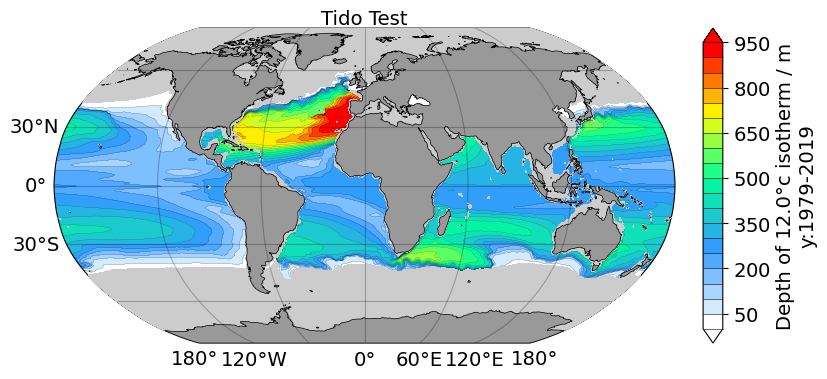

 --> elasped time to plot data: 0.93 min.


In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()